# Task 1 — Time Series Analysis with Linear Models
Dataset: Quarterly U.S. GDP (1947–2023)
Goal: Explore the series, determine linear model specs, train & evaluate, then compare to a second model.

In [1]:
# -------- 0) Imports & Settings --------
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.rcParams["figure.figsize"] = (9,4)
plt.rcParams["axes.grid"] = True
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

RAW_PATH = "../data/raw/GDP.csv"      # expects columns: observation_date, GDP
OUT_DIR  = "../data/processed"; os.makedirs(OUT_DIR, exist_ok=True)
CLEAN_CSV = os.path.join(OUT_DIR, "clean_gdp.csv")


## 1) Data Exploration & Preprocessing (4 pts)
- Load the quarterly GDP (1947–2023) and normalize to quarter-end (Q-DEC).
- Plot the level series.

Loaded: 1947-03-31 → 2025-06-30 (n=314)


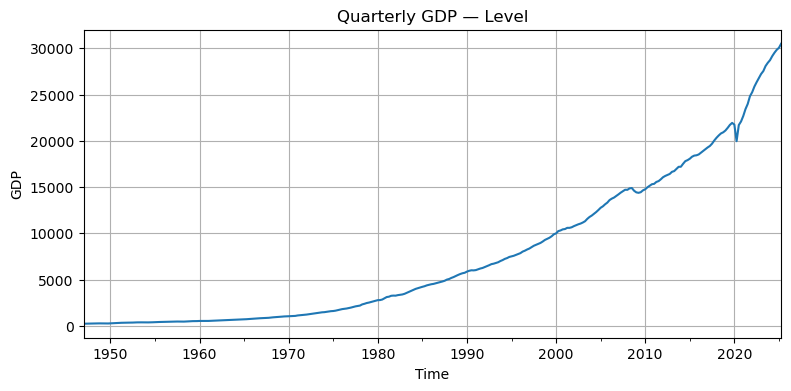

In [2]:
# Load & clean; keep it short and explicit
df = pd.read_csv(RAW_PATH)[["observation_date","GDP"]].rename(columns={"observation_date":"date"})
df["date"] = pd.to_datetime(df["date"])
df["GDP"]  = pd.to_numeric(df["GDP"], errors="coerce")
df = df.dropna().sort_values("date")

y = df.set_index("date")["GDP"]
y.index = y.index.to_period("Q-DEC").to_timestamp("Q")
y = y.asfreq("Q-DEC")

# save clean
y.rename("GDP").reset_index().to_csv(CLEAN_CSV, index=False)

print(f"Loaded: {y.index.min().date()} → {y.index.max().date()} (n={len(y)})")
y.plot(title="Quarterly GDP — Level"); plt.xlabel("Time"); plt.ylabel("GDP"); plt.show()


## 2) Model Determination (22 pts)
- Decomposition: Additive vs multiplicative
- Stationarity (ADF): pick d
- ACF/PACF: pick p,q
- Seasonality: check P,D,Q,s if needed
- Final choice: pick a linear model with reasoning

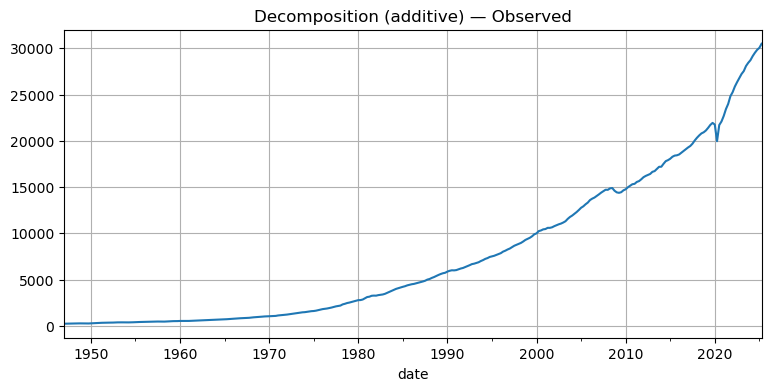

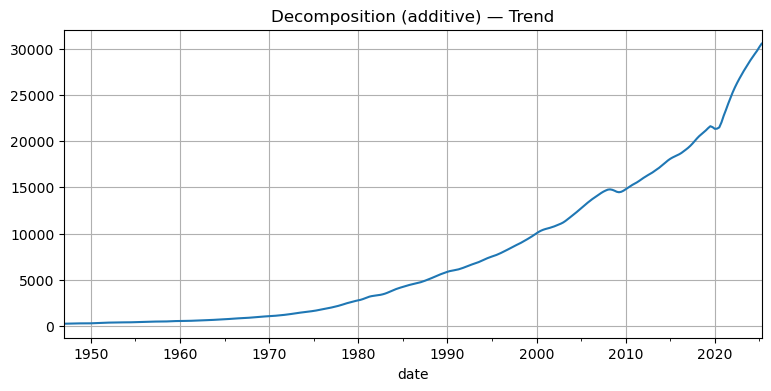

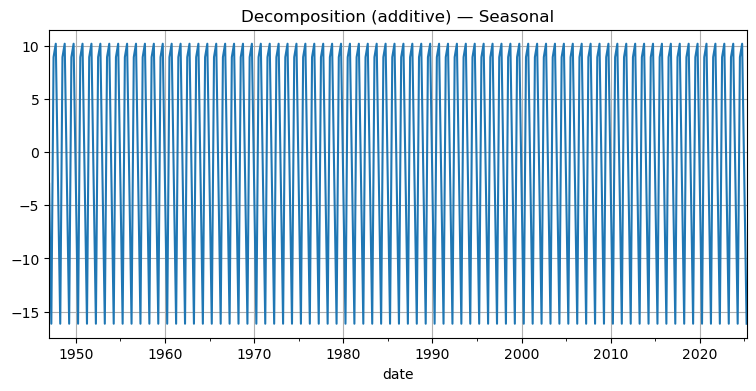

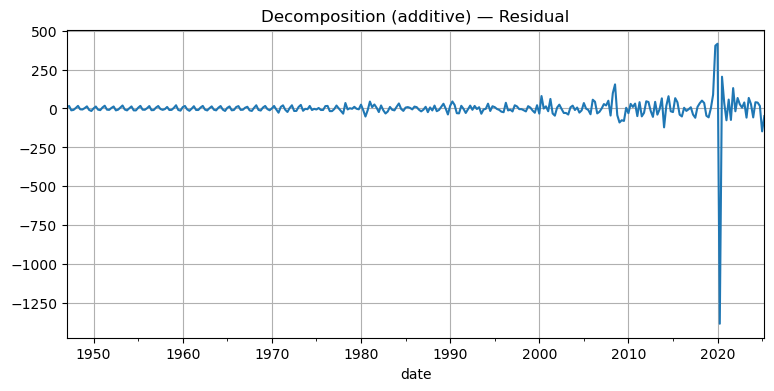

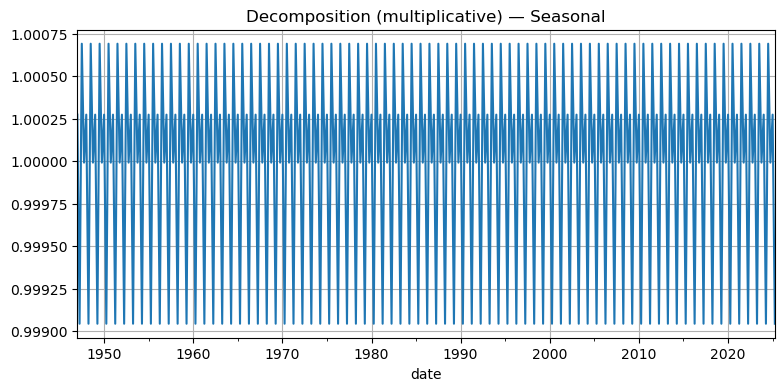

,Series,ADF stat,p,lags,N,cv(1%),cv(5%),cv(10%)
0,level,9.4208,1.0000,1,312,-3.4515,-2.8708,-2.5717
1,log(level),-2.1416,0.2281,2,311,-3.4516,-2.8709,-2.5717
2,"diff(level,1)",-3.7901,0.0030,4,308,-3.4518,-2.8710,-2.5718
3,"diff(log(level),1)",-8.6887,0.0000,1,311,-3.4516,-2.8709,-2.5717
4,seasonal_diff(s=4),2.0868,0.9988,16,293,-3.4529,-2.8715,-2.5721


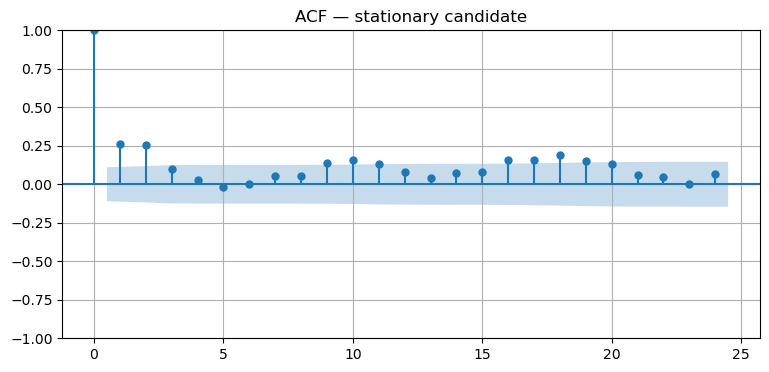

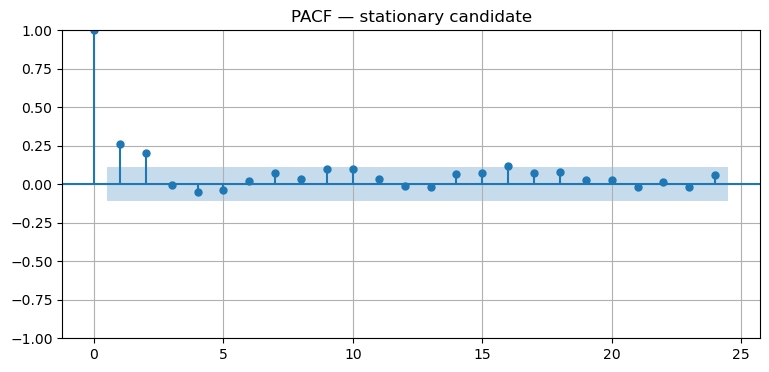

In [3]:
per = 4  # quarterly

# Decomposition (additive always; multiplicative only if strictly positive)
res_add = seasonal_decompose(y, model="additive", period=per, extrapolate_trend="freq")
res_add.observed.plot(title="Decomposition (additive) — Observed"); plt.show()
res_add.trend.plot(title="Decomposition (additive) — Trend"); plt.show()
res_add.seasonal.plot(title="Decomposition (additive) — Seasonal"); plt.show()
res_add.resid.plot(title="Decomposition (additive) — Residual"); plt.show()

# Multiplicative seasonal curve for reference (GDP>0)
res_mul = seasonal_decompose(y, model="multiplicative", period=per, extrapolate_trend="freq")
res_mul.seasonal.plot(title="Decomposition (multiplicative) — Seasonal"); plt.show()

# ADF table (concise)
def adf_row(x, name):
    a = adfuller(x.dropna(), autolag="AIC")
    return pd.Series({"Series": name, "ADF stat": a[0], "p": a[1], "lags": a[2], "N": a[3],
                      "cv(1%)": a[4]["1%"], "cv(5%)": a[4]["5%"], "cv(10%)": a[4]["10%"]})

rows = []
rows.append(adf_row(y, "level"))
yl = np.log(y)
rows.append(adf_row(yl, "log(level)"))
rows.append(adf_row(y.diff(), "diff(level,1)"))
rows.append(adf_row(yl.diff(), "diff(log(level),1)"))
rows.append(adf_row(y.diff(per), f"seasonal_diff(s={per})"))

adf_tbl = pd.DataFrame(rows)
display(adf_tbl)

# ACF/PACF on a stationary candidate (prefer diff(log))
cand = yl.diff().dropna()
plot_acf(cand, lags=24, title="ACF — stationary candidate"); plt.show()
plot_pacf(cand, lags=24, method="ywm", title="PACF — stationary candidate"); plt.show()


### Notes (my own reading of the diagnostics)
- Decomposition: seasonal ratio stays close to 1 → additive is enough; seasonal amplitude is weak.
- ADF (given my runs):
- level: p≈1.0000 (non-stationary)
- log(level): p≈0.2281 (non-stationary)
- diff(level,1): p≈0.0030 (stationary)
- diff(log(level),1): p≈0.0000 (stationary)
- seasonal_diff(s=4): p≈0.9988 (no seasonal unit root)
- No seasonal differencing (D=0).
- ACF/PACF (my read): PACF shows a clear spike at lag 1 (maybe 2); ACF decays gradually rather than cutting off; no strong spikes at 4,8,12.
⇒ Small AR component + weak MA; no seasonal ARMA parts.
- Model choice: ARIMA(1,1,1) with drift on log(GDP).
Rationale: d=1 from ADF; PACF suggests AR(1); MA(1) helps residual autocorrelation; drift reflects average growth.

## 3) Model Training & Evaluation (12 pts)
- 80/20 split (time-based; no look-ahead).
- Train the selected model.
- Rolling 1-step-ahead forecasts on the test window.
- Evaluate with RMSE / MAE / MAPE.

Train: 1947-03-31 → 2009-09-30 (n=251)
Test : 2009-12-31  → 2025-06-30  (n=63)
[1-step] ARIMA(1,1,1)+drift  RMSE=416.3578  MAE=163.0454  MAPE=0.7885%


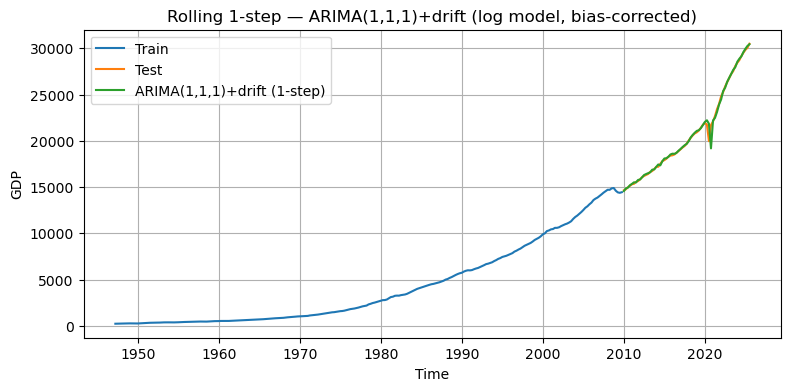

In [4]:
def tsplit(s, r=0.8):
    s = s.dropna()
    k = int(np.floor(len(s)*r))
    return s.iloc[:k], s.iloc[k:]

def align_xy(a, b):
    z = pd.concat([a, b], axis=1, join="inner").dropna()
    return z.iloc[:,0].to_numpy(float), z.iloc[:,1].to_numpy(float)

def mape_np(a,b):
    return np.mean(np.abs((a-b)/a))*100

train, test = tsplit(y, 0.8)
print(f"Train: {train.index.min().date()} → {train.index.max().date()} (n={len(train)})")
print(f"Test : {test.index.min().date()}  → {test.index.max().date()}  (n={len(test)})")

# Model 1: ARIMA(1,1,1)+drift on log scale — rolling 1-step
# (fit once on train for summary; then walk-forward for fair eval)
m1_train = ARIMA(np.log(train), order=(1,1,1), trend="t").fit()

pred1_list = []
for t in test.index:
    end = t - y.index.freq           # use data up to t-1
    res = ARIMA(np.log(y.loc[:end]), order=(1,1,1), trend="t").fit()
    fc  = res.get_forecast(steps=1)
    mu, var = fc.predicted_mean, fc.var_pred_mean
    pred1_list.append(np.exp(mu + 0.5*var).iloc[-1])  # bias-correct back to level

pred1 = pd.Series(pred1_list, index=test.index)

yt1, yp1 = align_xy(test, pred1)
rmse1 = np.sqrt(mean_squared_error(yt1, yp1))
mae1  = mean_absolute_error(yt1, yp1)
mape1 = mape_np(yt1, yp1)
print(f"[1-step] ARIMA(1,1,1)+drift  RMSE={rmse1:,.4f}  MAE={mae1:,.4f}  MAPE={mape1:,.4f}%")

plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, pred1, label="ARIMA(1,1,1)+drift (1-step)")
plt.title("Rolling 1-step — ARIMA(1,1,1)+drift (log model, bias-corrected)")
plt.xlabel("Time"); plt.ylabel("GDP"); plt.legend(); plt.show()


- RMSE (Root Mean Squared Error)
Measures the square-penalized average mistake, then root → GDP units.
Emphasis: punishes large errors; risk-sensitive. Lower is better.
Here: ARIMA(1,1,1) slightly lower → fewer big misses.

- MAE (Mean Absolute Error)
Average absolute miss in GDP units.
Emphasis: the typical quarter-to-quarter error; robust to outliers vs RMSE. Lower is better.
Here: ARIMA(1,1,1) smaller → tighter typical error.

- MAPE (Mean Absolute Percentage Error)
Average percent miss (unitless).
Emphasis: scale-free comparability; meaningful since GDP ≫ 0. Lower is better.
Here: both < 1%; ARIMA(1,1,1) smallest → best relative accuracy.

- All three metrics agree—ARIMA(1,1,1)+drift is marginally better; errors are economically small (MAPE < 1%).

## 4) Comparative Analysis (12 pts)
- Second model: ARIMA(2,1,1)+drift (same 1-step protocol).
- Compare metrics & overlay plots.
- Discuss strengths/weaknesses.

[1-step] ARIMA(2,1,1)+drift  RMSE=418.8951  MAE=169.8218  MAPE=0.8212%


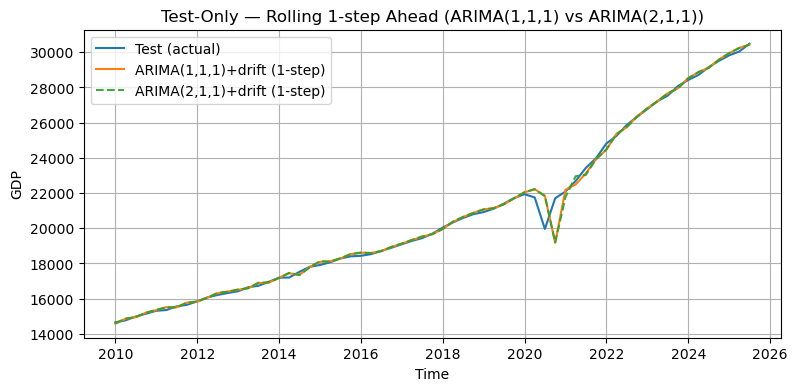


[1-step ahead] Comparison:
                   Model     RMSE      MAE  MAPE%
ARIMA(1,1,1)+drift [log] 416.3578 163.0454 0.7885
ARIMA(2,1,1)+drift [log] 418.8951 169.8218 0.8212


In [11]:
# Model 2: ARIMA(2,1,1)+drift on log scale — rolling 1-step
import warnings
warnings.filterwarnings("ignore")

m2_train = ARIMA(np.log(train), order=(2,1,1), trend="t").fit()
pred2_list = []
for t in test.index:
    end = t - y.index.freq
    res2 = ARIMA(np.log(y.loc[:end]), order=(2,1,1), trend="t").fit()
    fc2  = res2.get_forecast(steps=1)
    mu2, var2 = fc2.predicted_mean, fc2.var_pred_mean
    pred2_list.append(np.exp(mu2 + 0.5*var2).iloc[-1])
pred2 = pd.Series(pred2_list, index=test.index)

yt2, yp2 = align_xy(test, pred2)
rmse2 = np.sqrt(mean_squared_error(yt2, yp2))
mae2  = mean_absolute_error(yt2, yp2)
mape2 = mape_np(yt2, yp2)
print(f"[1-step] ARIMA(2,1,1)+drift  RMSE={rmse2:,.4f}  MAE={mae2:,.4f}  MAPE={mape2:,.4f}%")

# Test-only overlay
plt.plot(test.index, test, label="Test (actual)")
plt.plot(test.index, pred1, label="ARIMA(1,1,1)+drift (1-step)")
plt.plot(test.index, pred2, label="ARIMA(2,1,1)+drift (1-step)", linestyle="--", alpha=0.9)
plt.title("Test-Only — Rolling 1-step Ahead (ARIMA(1,1,1) vs ARIMA(2,1,1))")
plt.xlabel("Time"); plt.ylabel("GDP"); plt.legend(); plt.show()

# Comparison table
cmp = pd.DataFrame({
    "Model": ["ARIMA(1,1,1)+drift [log]", "ARIMA(2,1,1)+drift [log]"],
    "RMSE":  [rmse1, rmse2],
    "MAE":   [mae1,  mae2],
    "MAPE%": [mape1, mape2]
}).sort_values("RMSE")
print("\n[1-step ahead] Comparison:")
print(cmp.to_string(index=False))


### Notes (comparison & diagnostics)
- 1-step metrics from my run:
- ARIMA(1,1,1)+drift: RMSE 416.36, MAE 163.05, MAPE 0.789%
- ARIMA(2,1,1)+drift: RMSE 418.90, MAE 169.82, MAPE 0.821%
-> The (1,1,1) spec is slightly better across all metrics, and it is simpler.
- Residual white-noise (train fits): Ljung–Box p-values @ lags 8/12/16 ~ 1.0 for both models → no remaining autocorrelation structure at those lags.

In [13]:
# Residual white-noise checks (train fits)
lb1 = acorr_ljungbox(m1_train.resid.dropna(), lags=[8,12,16], return_df=True)
lb2 = acorr_ljungbox(m2_train.resid.dropna(), lags=[8,12,16], return_df=True)
print("\nLjung–Box p-values (ARIMA(1,1,1)+drift, train):")
print(lb1[["lb_pvalue"]])
print("\nLjung–Box p-values (ARIMA(2,1,1)+drift, train):")
print(lb2[["lb_pvalue"]])



Ljung–Box p-values (ARIMA(1,1,1)+drift, train):
    lb_pvalue
8      1.0000
12     1.0000
16     1.0000

Ljung–Box p-values (ARIMA(2,1,1)+drift, train):
    lb_pvalue
8      1.0000
12     1.0000
16     1.0000


### Strengths & Weaknesses
- ARIMA(1,1,1)+drift: parsimonious; captures mean growth (drift) and short-memory autocorr; slightly better out-of-sample errors here.
- ARIMA(2,1,1)+drift: a bit more flexible on AR side; similar diagnostics; slightly worse errors (likely over-parametrized for this series).
- Seasonality: not compelling in diagnostics (no spikes at multiples of 4); kept s=4 only as frequency meta (no seasonal terms).

# Task 2 — Stationarity of AR Models

*Assumption:*  $\{\varepsilon_t\}$ is white noise with mean $0$ and variance $\sigma^2$.

---

## Part 1 (2 pts): AR(1)

**Model**

$$
X_t = \phi X_{t-1} + \varepsilon_t, 
\quad \Phi(z) = 1 - \phi z, 
\quad z_1 = 1/\phi .
$$

**⇐ Sufficiency ($|\phi|<1 \iff |z_1|>1$)**  

$$
X_t = \sum_{j=0}^{\infty} \phi^{\,j} \varepsilon_{t-j}
\quad \text{(converges if } \sum_{j\ge0} |\phi|^j < \infty \iff |\phi|<1 \text{)}.
$$

$$
\mathbb{E}[X_t]=0,
\qquad
\gamma(h)=\operatorname{Cov}(X_t,X_{t-h})=\frac{\sigma^2 \phi^{|h|}}{1-\phi^2},
$$

which depends only on $|h|$ ⇒ weakly stationary.

**⇒ Necessity (stationary $\Rightarrow |\phi|<1$)**  

If $|\phi|\ge 1$, the homogeneous solution $X_t^h = C \phi^{\,t}$ is non-decaying ($|\phi|=1$) or explosive ($|\phi|>1$);  
variance becomes time-varying or infinite ⇒ not stationary.  

Hence $|\phi|<1 \iff |z_1|>1$.

---

## Part 2 (8 pts): AR($p$)

**Model / Lag form**

$$
X_t = \phi_1 X_{t-1} + \cdots + \phi_p X_{t-p} + \varepsilon_t,
\quad 
\Phi(L) X_t = \varepsilon_t,
\quad 
\Phi(z) = 1 - \phi_1 z - \cdots - \phi_p z^p .
$$

**⇐ Sufficiency (all roots of $\Phi$ outside unit circle)**  

If every root $z_i$ of $\Phi(z)=0$ satisfies $|z_i|>1$, then $\Phi(z)\neq 0$ for $|z|\le 1$, so

$$
\Phi(L)^{-1} = \sum_{j=0}^{\infty} \psi_j L^j, 
\qquad 
\sum_{j=0}^{\infty} |\psi_j| < \infty,
$$

$$
X_t = \Phi(L)^{-1} \varepsilon_t = \sum_{j=0}^{\infty} \psi_j \varepsilon_{t-j}.
$$

Absolute summability ⇒ $\mathbb{E}[X_t]=0$ and  

$$
\gamma(h) = \sigma^2 \sum_{j\ge 0} \psi_j \psi_{j+|h|},
$$

which depends only on $|h|$ ⇒ weakly stationary.

**⇒ Necessity (stationary $\Rightarrow$ all roots outside)**  

Homogeneous recursion:

$$
X_t^h = \phi_1 X_{t-1}^h + \cdots + \phi_p X_{t-p}^h.
$$

General solution:

$$
X_t^h = \sum_{i=1}^{m} \sum_{k=0}^{m_i-1} c_{ik}\, t^{k}\, r_i^{\,t},
$$

where $r_i$ solve

$$
r^p - \phi_1 r^{p-1} - \cdots - \phi_p = 0
\quad \Longleftrightarrow \quad \Phi(1/r)=0 .
$$

If any $|r_i|\ge 1$ (equivalently some root $z_i=1/r_i$ has $|z_i|\le 1$), then $X_t^h$ is non-decaying/explosive  
(or polynomially growing when $|r_i|=1$ with multiplicity) ⇒ time-varying or infinite variance ⇒ not stationary.  

Therefore all $|r_i|<1$ ⇔ all roots of $\Phi(z)=0$ satisfy $|z_i|>1$.

---

**Conclusion**

An AR model is (weakly) stationary **iff** all roots of its characteristic polynomial lie **outside** the unit circle.


# Task 3 —— PCA from Scratch — Wine Quality (Red)

In [15]:
# 0) Imports & Settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["axes.grid"] = True
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

RAW_CSV = "../data/raw/winequality-red.csv"


## 1) PCAFromScratch (inline, no PCA libraries)
Steps: center/standardize → covariance → eigen-decomposition → sort → keep top-k → project.

In [16]:
import numpy as np
from typing import Optional, Tuple

class PCAFromScratch:
    def __init__(self, n_components: Optional[int] = None, standardize: bool = True) -> None:
        self.n_components = n_components
        self.standardize = standardize
        # learned params
        self.mean_: Optional[np.ndarray] = None
        self.std_: Optional[np.ndarray] = None
        self.components_: Optional[np.ndarray] = None   # shape: (n_features, k)
        self.explained_variance_: Optional[np.ndarray] = None
        self.explained_variance_ratio_: Optional[np.ndarray] = None

    def fit(self, X: np.ndarray) -> "PCAFromScratch":
        X = self._as_2d_float_array(X, name="X")
        n, d = X.shape
        if self.n_components is not None:
            if not (1 <= self.n_components <= d):
                raise ValueError(f"n_components must be in [1, {d}] or None.")

        # 1) center
        self.mean_ = X.mean(axis=0)
        Xc = X - self.mean_

        # 2) standardize (optional)
        if self.standardize:
            std = Xc.std(axis=0, ddof=1)          # sample std
            std_safe = np.where(std == 0, 1.0, std)
            self.std_ = std_safe
            Xc = Xc / std_safe
        else:
            self.std_ = None

        # 3) covariance (features in columns)
        cov = np.cov(Xc, rowvar=False)

        # 4) eigen-decomposition (cov is symmetric PSD)
        eigvals, eigvecs = np.linalg.eigh(cov)    # ascending
        order = np.argsort(eigvals)[::-1]         # descending
        eigvals = eigvals[order]
        eigvecs = eigvecs[:, order]

        # 5) keep first k (if requested)
        if self.n_components is not None:
            k = self.n_components
            eigvals = eigvals[:k]
            eigvecs = eigvecs[:, :k]

        # 6) save
        self.components_ = eigvecs
        eigvals = np.maximum(eigvals, 0.0)        # clip tiny negatives (round-off)
        self.explained_variance_ = eigvals

        # denominator uses sum of all eigenvalues of cov (not just top-k)
        full = np.maximum(np.linalg.eigvalsh(cov), 0.0)  # ascending
        total = full.sum()
        self.explained_variance_ratio_ = eigvals / (total + 1e-12)
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        self._check_fitted()
        X = self._as_2d_float_array(X, name="X")
        Xc = X - self.mean_
        if self.standardize:
            Xc = Xc / self.std_
        return Xc @ self.components_

    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        return self.fit(X).transform(X)

    def inverse_transform(self, Z: np.ndarray) -> np.ndarray:
        self._check_fitted()
        Z = np.asarray(Z, dtype=float)
        if Z.ndim != 2 or Z.shape[1] != self.components_.shape[1]:
            raise ValueError(f"Z must be [n_samples, {self.components_.shape[1]}].")
        Xc = Z @ self.components_.T
        if self.standardize:
            Xc = Xc * self.std_
        return Xc + self.mean_

    def scree_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        self._check_fitted()
        eig = self.explained_variance_.copy()
        ratio = self.explained_variance_ratio_.copy()
        cum = np.cumsum(ratio)
        return eig, ratio, cum

    @staticmethod
    def _as_2d_float_array(X: np.ndarray, name: str) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        if X.ndim != 2:
            raise ValueError(f"{name} must be 2D: got {X.shape}.")
        return X

    def _check_fitted(self) -> None:
        if self.components_ is None or self.mean_ is None:
            raise RuntimeError("PCA is not fitted yet. Call fit(X) first.")


## 2) Load data and split features/label

In [17]:
df = pd.read_csv(RAW_CSV, sep=";")
X = df.drop(columns=["quality"]).values
y = df["quality"].values

print("Shape:", X.shape, "| features =", X.shape[1])
df.head(3)


Shape: (1599, 11) | features = 11


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4000,0.7000,0.0000,1.9000,0.0760,11.0000,34.0000,0.9978,3.5100,0.5600,9.4000,5
1,7.8000,0.8800,0.0000,2.6000,0.0980,25.0000,67.0000,0.9968,3.2000,0.6800,9.8000,5
2,7.8000,0.7600,0.0400,2.3000,0.0920,15.0000,54.0000,0.9970,3.2600,0.6500,9.8000,5


## 3) Fit PCA (full), get explained variance data
Standardize inside PCA (zero-mean, unit-std), then eigen-decompose the covariance.

In [18]:
pca = PCAFromScratch(n_components=None, standardize=True)
Z = pca.fit_transform(X)   # same dimension as X for now

eig, ratio, cum = pca.scree_data()
print(f"Top-3 cumulative explained variance: {cum[2]:.4f}")


Top-3 cumulative explained variance: 0.5978


## 4) Scree & cumulative plots
Look for the elbow and how fast the cumulative curve saturates.

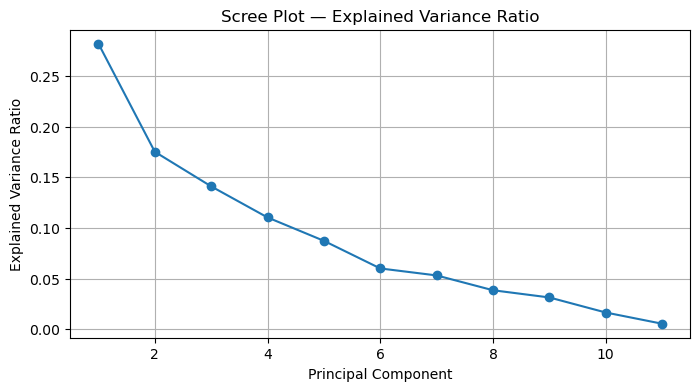

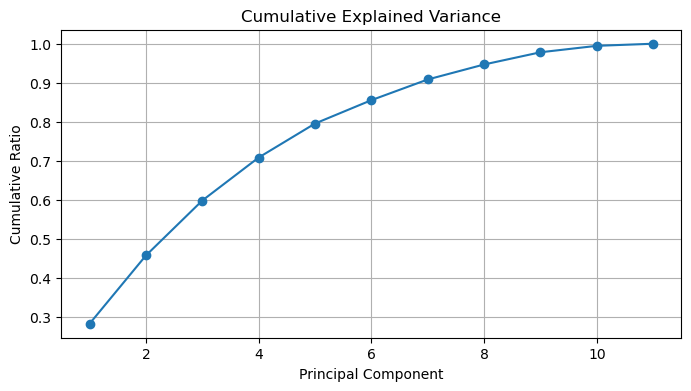

In [19]:
# Scree plot (per-PC explained variance ratio)
plt.plot(range(1, len(ratio)+1), ratio, marker="o")
plt.title("Scree Plot — Explained Variance Ratio")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.show()

# Cumulative explained variance
plt.plot(range(1, len(cum)+1), cum, marker="o")
plt.title("Cumulative Explained Variance")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Ratio")
plt.show()


## 5) 2D / 3D projections using top PCs
Color by the original quality for intuition only (unsupervised).

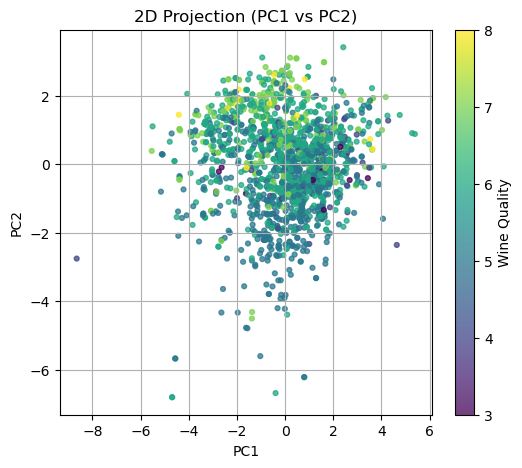

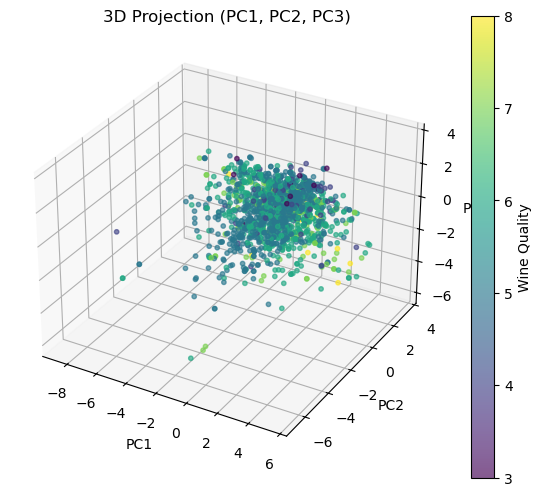

In [22]:
# 2D (PC1 vs PC2)
Z2 = Z[:, :2]
plt.figure(figsize=(6,5))
sc = plt.scatter(Z2[:,0], Z2[:,1], c=y, cmap="viridis", s=12, alpha=0.75)
plt.title("2D Projection (PC1 vs PC2)")
plt.xlabel("PC1"); plt.ylabel("PC2")
cb = plt.colorbar(sc); cb.set_label("Wine Quality")
plt.show()

# 3D (PC1, PC2, PC3)
from mpl_toolkits.mplot3d import Axes3D 

Z3 = Z[:, :3]
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(Z3[:,0], Z3[:,1], Z3[:,2], c=y, cmap="viridis", s=10, alpha=0.65)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
ax.set_title("3D Projection (PC1, PC2, PC3)")
fig.colorbar(p, ax=ax, label="Wine Quality")
plt.show()


## 6) Parameter analysis: downstream task vs #PCs
Binary target (quality ≥ 6 → 1).
PCA is fit on train only, then applied to both train/test to avoid leakage.

Best k=9, accuracy=0.7531


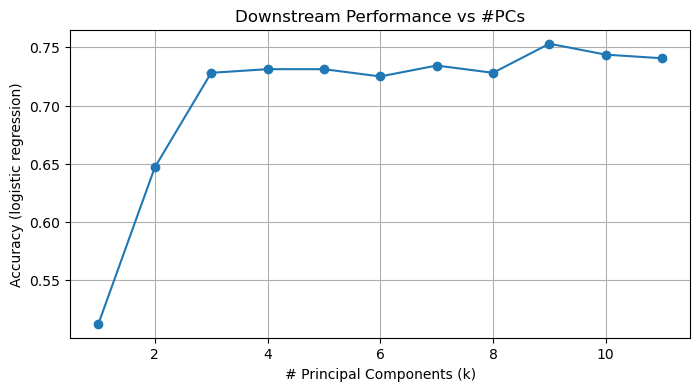

In [21]:
y_bin = (y >= 6).astype(int)

Xtr, Xte, ytr, yte = train_test_split(
    X, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

ks, accs = [], []
for k in range(1, X.shape[1] + 1):
    p = PCAFromScratch(n_components=k, standardize=True).fit(Xtr)
    Ztr, Zte = p.transform(Xtr), p.transform(Xte)
    clf = LogisticRegression(max_iter=400).fit(Ztr, ytr)
    accs.append(accuracy_score(yte, clf.predict(Zte)))
    ks.append(k)

best_k = int(ks[int(np.argmax(accs))])
best_acc = float(np.max(accs))
print(f"Best k={best_k}, accuracy={best_acc:.4f}")

plt.plot(ks, accs, marker="o")
plt.xlabel("# Principal Components (k)")
plt.ylabel("Accuracy (logistic regression)")
plt.title("Downstream Performance vs #PCs")
plt.show()


### Analysis
- Best result: k = 9 principal components with Accuracy ≈ 0.753.

- Rapid gains: Accuracy jumps from k = 1 → 3, indicating strong low-dimensional structure.

- Plateau: Performance stabilizes for k ≈ 3–8 (diminishing returns).

- After peak: Accuracy does not improve beyond k = 9 and slightly drifts down (noise/overfit risk).

### Insights
- Early PCs capture most discriminative signal; later PCs add fine-grained/mostly noisy variation.

- The small lift at k = 9 may be within sampling variability; repeated splits or CV would confirm.

### Conclusion
- Considering simplicity & robustness: choose k = 6–8 (nearly the same accuracy with fewer dimensions).

## 7)Summary
- Implementation (no PCA libs): center/standardize → covariance → eigh → sort → top-
𝑘
k → project; explained variance uses sum of all eigenvalues as denominator.
- Visualization: scree + cumulative; 2D/3D plots with top PCs.
- Parameter analysis: PCA fit on train; logistic regression on projected data; report best 
𝑘
k and accuracy.